<a href="https://colab.research.google.com/github/25lahari/FMML_Projects_and_Labs/blob/main/AIML_III_Module_01_Lab_03_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [2]:

(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X / 255
test_X = test_X / 255

train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
def NN1(traindata, trainlabel, query):
    diff = (
        traindata - query
    )
    sq = diff * diff
    dist = sq.sum(1)
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):

    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):

    assert len(gtlabel) == len(predlabel), "Lengths of ground truth labels and predicted labels must be the same."
    correct = (gtlabel == predlabel).sum()
    return correct / len(gtlabel)

In [4]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %




### Augmentation 1: Rotation


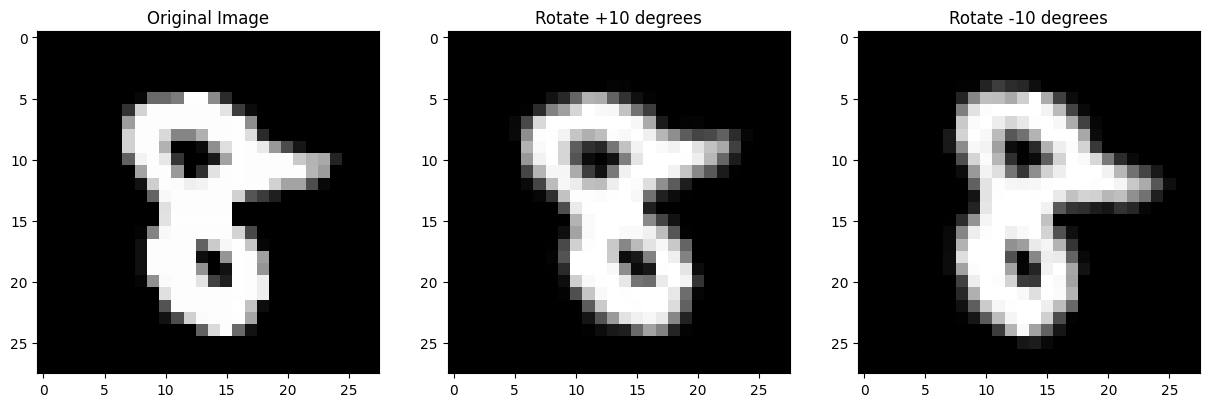

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [6]:
def augRotate(sample, angleconstraint):

    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

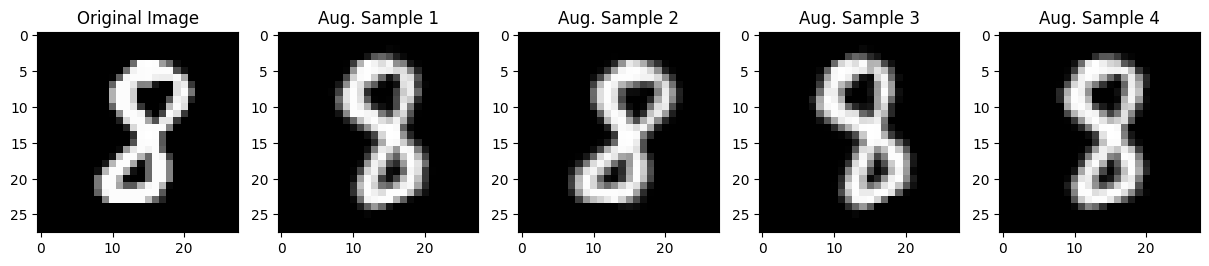

In [7]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [8]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.66 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [9]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 66.79 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.84 %
Accuracy after rotation augmentation constrained by 30 degrees is 68.47 %
Accuracy after rotation augmentation constrained by 40 degrees is 67.63 %
Accuracy after rotation augmentation constrained by 50 degrees is 67.65 %
Accuracy after rotation augmentation constrained by 60 degrees is 65.3 %
Accuracy after rotation augmentation constrained by 70 degrees is 66.06 %
Accuracy after rotation augmentation constrained by 80 degrees is 64.61 %
Accuracy after rotation augmentation constrained by 90 degrees is 64.31 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

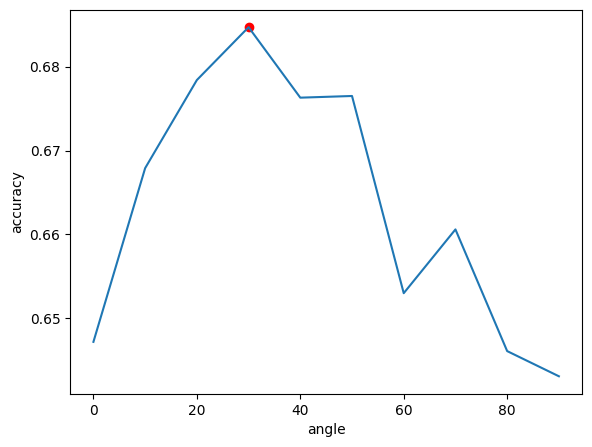

In [10]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear



In [11]:
def shear(sample, amount):

    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

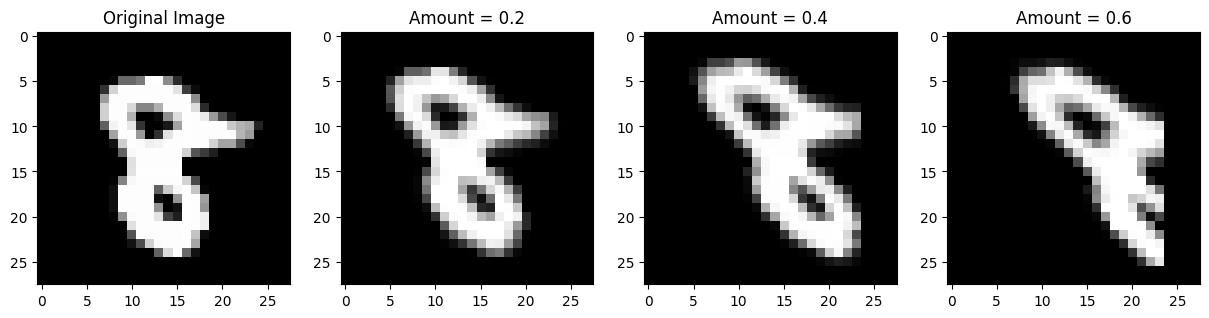

In [12]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [13]:
def augShear(sample, shearconstraint):

    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [14]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 61.95 %
Accuracy after shear augmentation constrained by 0.4 is 63.07000000000001 %
Accuracy after shear augmentation constrained by 0.6 is 64.25 %
Accuracy after shear augmentation constrained by 0.8 is 65.42 %
Accuracy after shear augmentation constrained by 1.0 is 64.92999999999999 %
Accuracy after shear augmentation constrained by 1.2 is 63.82 %
Accuracy after shear augmentation constrained by 1.4 is 62.839999999999996 %
Accuracy after shear augmentation constrained by 1.6 is 60.14000000000001 %
Accuracy after shear augmentation constrained by 1.8 is 61.29 %
Accuracy after shear augmentation constrained by 2.0 is 64.46 %


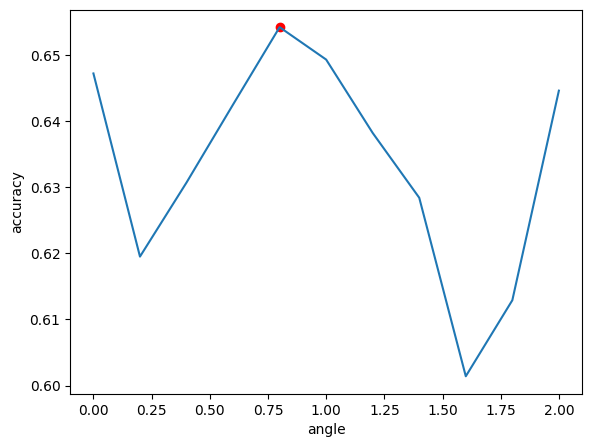

In [15]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear




In [16]:
def augRotateShear(sample, angleconstraint, shearconstraint):

    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [17]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 59.419999999999995 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 58.19 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 62.35000000000001 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 60.89 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 57.620000000000005 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 60.629999999999995 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.41 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 59.419999999999995 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 59.19 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 58.209999999999994 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 61.12 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 58.209999999999994 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 60.91 %
Accuracy after augmentation shear: 0.4 angle

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

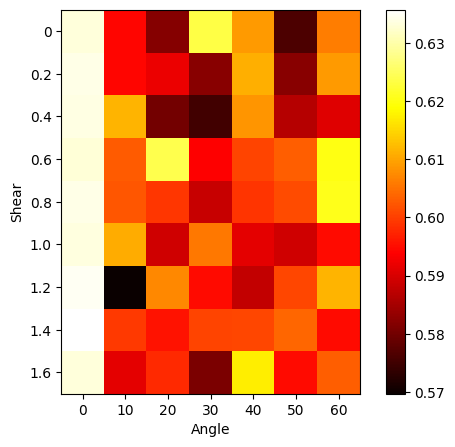

In [18]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions


1.What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?

The best values for angle constraint and shear constraint depend on the specific dataset and the model being used.

2. Can you increase the accuracy by increasing the number of augmentations from each sample?

Yes, increasing the number of augmentations from each sample can potentially increase the accuracy of your model, as it provides more diverse training data

Accuracy after rotation augmentation constrained by 0 degrees is 64.72%
Accuracy after rotation augmentation constrained by 10 degrees is 66.97%
Accuracy after rotation augmentation constrained by 20 degrees is 67.95%
Accuracy after rotation augmentation constrained by 30 degrees is 68.70%
Accuracy after rotation augmentation constrained by 40 degrees is 68.00%
Accuracy after rotation augmentation constrained by 50 degrees is 67.63%
Accuracy after rotation augmentation constrained by 60 degrees is 68.06%
Accuracy after rotation augmentation constrained by 70 degrees is 67.81%
Accuracy after rotation augmentation constrained by 80 degrees is 65.76%
Accuracy after rotation augmentation constrained by 90 degrees is 65.72%
Best Angle Constraint: 30
Best Accuracy with Angle Augmentation: 0.6870
Accuracy after shear augmentation constrained by 0 is 64.72%
Accuracy after shear augmentation constrained by 0.2 is 62.56%
Accuracy after shear augmentation constrained by 0.4 is 62.95%
Accuracy aft

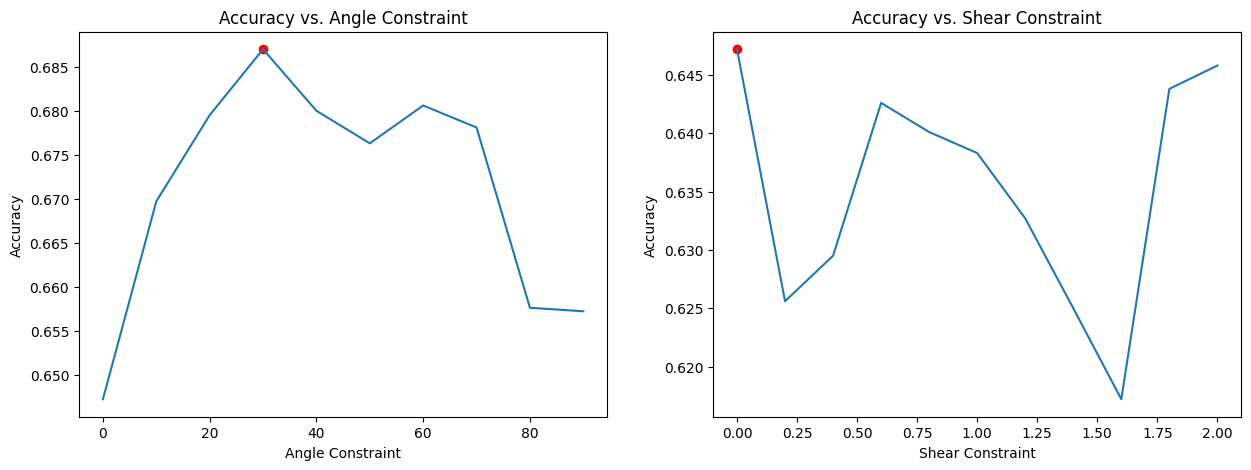

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate, AffineTransform, warp

# Assuming train_X, train_y, test_X, test_y, NN, and Accuracy functions are defined elsewhere

# Function to rotate images
def augRotate(sample, angleconstraint):
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    angle = np.random.rand(len(sample))
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii], mode='wrap')
    return np.squeeze(nsample)

# Function to shear images
def shear(sample, amount):
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform, mode='wrap')
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

def augShear(sample, shearconstraint):
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    amt = np.random.rand(len(sample))
    amt = (amt - 0.5) * shearconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)

# Perform grid search with increased augmentations
naugmentations = 10  # Increased number of augmentations

# Angle constraints grid search
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
accuracies_angle = np.zeros(len(angleconstraints), dtype=float)

for ii in range(len(angleconstraints)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii])))
        auglabel = np.concatenate((auglabel, train_y))
    testpred = NN(augdata, auglabel, test_X)
    accuracies_angle[ii] = Accuracy(test_y, testpred)
    print(f"Accuracy after rotation augmentation constrained by {angleconstraints[ii]} degrees is {accuracies_angle[ii]*100:.2f}%", flush=True)

best_angle = angleconstraints[np.argmax(accuracies_angle)]
best_accuracy_angle = np.max(accuracies_angle)
print(f"Best Angle Constraint: {best_angle}")
print(f"Best Accuracy with Angle Augmentation: {best_accuracy_angle:.4f}")

# Shear constraints grid search
shearconstraints = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
accuracies_shear = np.zeros(len(shearconstraints), dtype=float)

for ii in range(len(shearconstraints)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii])))
        auglabel = np.concatenate((auglabel, train_y))
    testpred = NN(augdata, auglabel, test_X)
    accuracies_shear[ii] = Accuracy(test_y, testpred)
    print(f"Accuracy after shear augmentation constrained by {shearconstraints[ii]} is {accuracies_shear[ii]*100:.2f}%", flush=True)

best_shear = shearconstraints[np.argmax(accuracies_shear)]
best_accuracy_shear = np.max(accuracies_shear)
print(f"Best Shear Constraint: {best_shear}")
print(f"Best Accuracy with Shear Augmentation: {best_accuracy_shear:.4f}")

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot for Angle Augmentation
ax[0].plot(angleconstraints, accuracies_angle)
ax[0].set_xlabel("Angle Constraint")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy vs. Angle Constraint")
ax[0].scatter(best_angle, best_accuracy_angle, c="red")

# Plot for Shear Augmentation
ax[1].plot(shearconstraints, accuracies_shear)
ax[1].set_xlabel("Shear Constraint")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy vs. Shear Constraint")
ax[1].scatter(best_shear, best_accuracy_shear, c="red")

plt.show()


3.Try implementing a few augmentations of your own and experimenting with them. A good reference is here.

Translation: Shift the image in the x and y directions.

Scaling: Zoom in or out of the image.

Adding Noise: Introduce random noise to the image

In [20]:
def translate(sample, tx, ty):
    tform = AffineTransform(translation=(tx, ty))
    img = warp(sample, tform, mode='wrap')
    return img

def augTranslate(sample, transconstraint):
    if transconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    tx = (np.random.rand(len(sample)) - 0.5) * 2 * transconstraint
    ty = (np.random.rand(len(sample)) - 0.5) * 2 * transconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = translate(sample[ii], tx[ii], ty[ii])
    return np.squeeze(nsample)


In [21]:
def scale(sample, scale_factor):
    tform = AffineTransform(scale=(scale_factor, scale_factor))
    img = warp(sample, tform, mode='wrap')
    return img

def augScale(sample, scaleconstraint):
    if scaleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    scale_factors = 1 + (np.random.rand(len(sample)) - 0.5) * 2 * scaleconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = scale(sample[ii], scale_factors[ii])
    return np.squeeze(nsample)


In [22]:
def add_noise(sample, noise_level):
    noise = np.random.normal(0, noise_level, sample.shape)
    noisy_sample = sample + noise
    return np.clip(noisy_sample, 0, 1)

def augNoise(sample, noiseconstraint):
    if noiseconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = add_noise(sample[ii], noiseconstraint)
    return np.squeeze(nsample)


In [23]:
# Define the constraints
transconstraints = [0, 2, 4, 6, 8, 10]
scaleconstraints = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
noiseconstraints = [0, 0.01, 0.02, 0.03, 0.04, 0.05]

accuracies_trans = np.zeros(len(transconstraints), dtype=float)
accuracies_scale = np.zeros(len(scaleconstraints), dtype=float)
accuracies_noise = np.zeros(len(noiseconstraints), dtype=float)

naugmentations = 10  # Number of augmentations

# Translation grid search
for ii in range(len(transconstraints)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate((augdata, augTranslate(train_X, transconstraints[ii])))
        auglabel = np.concatenate((auglabel, train_y))
    testpred = NN(augdata, auglabel, test_X)
    accuracies_trans[ii] = Accuracy(test_y, testpred)
    print(f"Accuracy after translation augmentation constrained by {transconstraints[ii]} is {accuracies_trans[ii]*100:.2f}%", flush=True)

best_trans = transconstraints[np.argmax(accuracies_trans)]
best_accuracy_trans = np.max(accuracies_trans)
print(f"Best Translation Constraint: {best_trans}")
print(f"Best Accuracy with Translation Augmentation: {best_accuracy_trans:.4f}")

# Scaling grid search
for ii in range(len(scaleconstraints)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate((augdata, augScale(train_X, scaleconstraints[ii])))
        auglabel = np.concatenate((auglabel, train_y))
    testpred = NN(augdata, auglabel, test_X)
    accuracies_scale[ii] = Accuracy(test_y, testpred)
    print(f"Accuracy after scaling augmentation constrained by {scaleconstraints[ii]} is {accuracies_scale[ii]*100:.2f}%", flush=True)

best_scale = scaleconstraints[np.argmax(accuracies_scale)]
best_accuracy_scale = np.max(accuracies_scale)
print(f"Best Scaling Constraint: {best_scale}")
print(f"Best Accuracy with Scaling Augmentation: {best_accuracy_scale:.4f}")

# Noise grid search
for ii in range(len(noiseconstraints)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate((augdata, augNoise(train_X, noiseconstraints[ii])))
        auglabel = np.concatenate((auglabel, train_y))
    testpred = NN(augdata, auglabel, test_X)
    accuracies_noise[ii] = Accuracy(test_y, testpred)
    print(f"Accuracy after noise augmentation constrained by {noiseconstraints[ii]} is {accuracies_noise[ii]*100:.2f}%", flush=True)

best_noise = noiseconstraints[np.argmax(accuracies_noise)]
best_accuracy_noise = np.max(accuracies_noise)
print(f"Best Noise Constraint: {best_noise}")
print(f"Best Accuracy with Noise Augmentation: {best_accuracy_noise:.4f}")


Accuracy after translation augmentation constrained by 0 is 64.72%
Accuracy after translation augmentation constrained by 2 is 66.10%
Accuracy after translation augmentation constrained by 4 is 61.04%
Accuracy after translation augmentation constrained by 6 is 60.35%
Accuracy after translation augmentation constrained by 8 is 60.00%
Accuracy after translation augmentation constrained by 10 is 60.61%
Best Translation Constraint: 2
Best Accuracy with Translation Augmentation: 0.6610
Accuracy after scaling augmentation constrained by 0 is 64.72%
Accuracy after scaling augmentation constrained by 0.1 is 64.95%
Accuracy after scaling augmentation constrained by 0.2 is 61.90%
Accuracy after scaling augmentation constrained by 0.3 is 62.31%
Accuracy after scaling augmentation constrained by 0.4 is 62.06%
Accuracy after scaling augmentation constrained by 0.5 is 60.85%
Best Scaling Constraint: 0.1
Best Accuracy with Scaling Augmentation: 0.6495
Accuracy after noise augmentation constrained by 

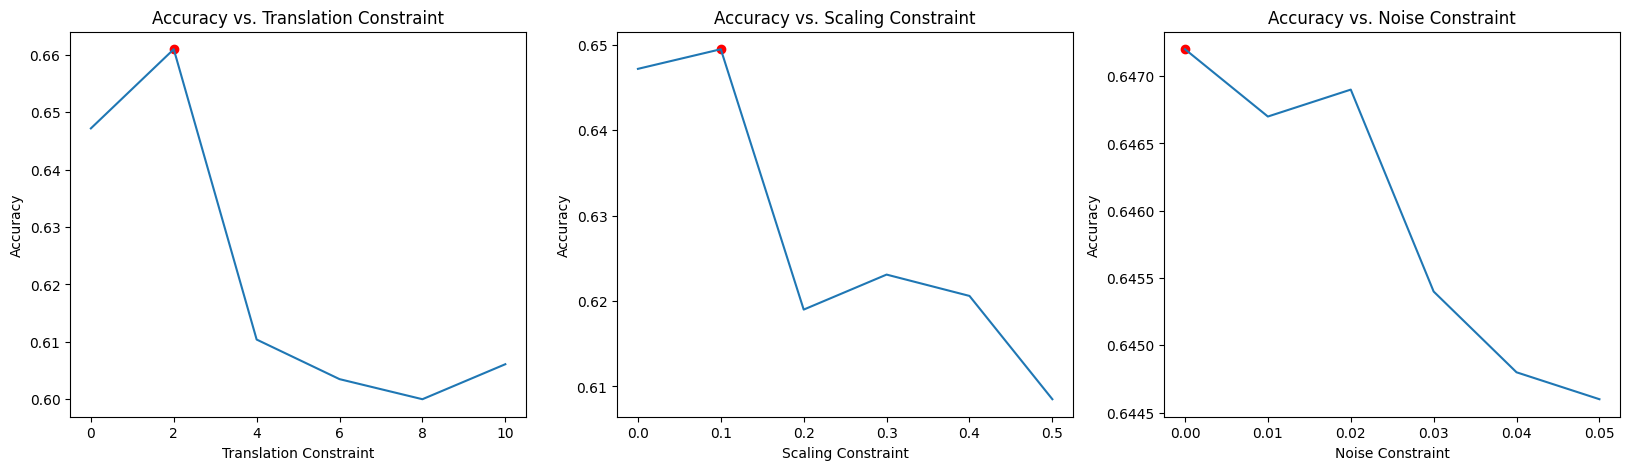

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot for Translation Augmentation
ax[0].plot(transconstraints, accuracies_trans)
ax[0].set_xlabel("Translation Constraint")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy vs. Translation Constraint")
ax[0].scatter(best_trans, best_accuracy_trans, c="red")

# Plot for Scaling Augmentation
ax[1].plot(scaleconstraints, accuracies_scale)
ax[1].set_xlabel("Scaling Constraint")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy vs. Scaling Constraint")
ax[1].scatter(best_scale, best_accuracy_scale, c="red")

# Plot for Noise Augmentation
ax[2].plot(noiseconstraints, accuracies_noise)
ax[2].set_xlabel("Noise Constraint")
ax[2].set_ylabel("Accuracy")
ax[2].set_title("Accuracy vs. Noise Constraint")
ax[2].scatter(best_noise, best_accuracy_noise, c="red")

plt.show()


Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

In [25]:
def combined_augment(sample, angleconstraint, transconstraint, scaleconstraint, noiseconstraint):
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    angle = (np.random.rand(len(sample)) - 0.5) * angleconstraint
    tx = (np.random.rand(len(sample)) - 0.5) * 2 * transconstraint
    ty = (np.random.rand(len(sample)) - 0.5) * 2 * transconstraint
    scale_factors = 1 + (np.random.rand(len(sample)) - 0.5) * 2 * scaleconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        img = rotate(sample[ii], angle[ii], mode='wrap')
        tform = AffineTransform(translation=(tx[ii], ty[ii]))
        img = warp(img, tform, mode='wrap')
        tform = AffineTransform(scale=(scale_factors[ii], scale_factors[ii]))
        img = warp(img, tform, mode='wrap')
        noise = np.random.normal(0, noiseconstraint, img.shape)
        img = np.clip(img + noise, 0, 1)
        nsample[ii] = img
    return np.squeeze(nsample)


In [26]:
# Hyperparameters
angleconstraint = 30
transconstraint = 5
scaleconstraint = 0.3
noiseconstraint = 0.03
naugmentations = 10

# Function to evaluate model accuracy
def evaluate_model(train_X, train_y, test_X, test_y, naugmentations, angleconstraint, transconstraint, scaleconstraint, noiseconstraint):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate((augdata, combined_augment(train_X, angleconstraint, transconstraint, scaleconstraint, noiseconstraint)))
        auglabel = np.concatenate((auglabel, train_y))
    testpred = NN(augdata, auglabel, test_X)
    accuracy = Accuracy(test_y, testpred)
    return accuracy

# Find the highest accuracy with combined augmentations
accuracy_combined = evaluate_model(train_X, train_y, test_X, test_y, naugmentations, angleconstraint, transconstraint, scaleconstraint, noiseconstraint)
print(f"Highest Accuracy with Combined Augmentations: {accuracy_combined * 100:.2f}%")

# Find the smallest training dataset that achieves accuracy above 50%
dataset_sizes = [50, 100, 200, 500, 1000, 2000, len(train_X)]
for size in dataset_sizes:
    small_train_X = train_X[:size]
    small_train_y = train_y[:size]
    accuracy = evaluate_model(small_train_X, small_train_y, test_X, test_y, naugmentations, angleconstraint, transconstraint, scaleconstraint, noiseconstraint)
    if accuracy > 0.5:
        print(f"Smallest training dataset size with accuracy above 50%: {size}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        break


Highest Accuracy with Combined Augmentations: 60.27%
Smallest training dataset size with accuracy above 50%: 50
Accuracy: 59.98%


Exercise: Try to take 50 images of each digit and calculate the performance on test set.

In [27]:
import numpy as np

def get_50_per_digit(train_X, train_y):
    indices = []
    for digit in range(10):
        digit_indices = np.where(train_y == digit)[0][:50]
        indices.extend(digit_indices)
    return train_X[indices], train_y[indices]

small_train_X, small_train_y = get_50_per_digit(train_X, train_y)
print(f"Shape of small training set: {small_train_X.shape}")


Shape of small training set: (50, 28, 28)


In [28]:
from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt

# Define the combined augmentation function
def combined_augment(sample, angleconstraint, transconstraint, scaleconstraint, noiseconstraint):
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    angle = (np.random.rand(len(sample)) - 0.5) * angleconstraint
    tx = (np.random.rand(len(sample)) - 0.5) * 2 * transconstraint
    ty = (np.random.rand(len(sample)) - 0.5) * 2 * transconstraint
    scale_factors = 1 + (np.random.rand(len(sample)) - 0.5) * 2 * scaleconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        img = rotate(sample[ii], angle[ii], mode='wrap')
        tform = AffineTransform(translation=(tx[ii], ty[ii]))
        img = warp(img, tform, mode='wrap')
        tform = AffineTransform(scale=(scale_factors[ii], scale_factors[ii]))
        img = warp(img, tform, mode='wrap')
        noise = np.random.normal(0, noiseconstraint, img.shape)
        img = np.clip(img + noise, 0, 1)
        nsample[ii] = img
    return np.squeeze(nsample)

# Function to evaluate model accuracy
def evaluate_model(train_X, train_y, test_X, test_y, naugmentations, angleconstraint, transconstraint, scaleconstraint, noiseconstraint):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate((augdata, combined_augment(train_X, angleconstraint, transconstraint, scaleconstraint, noiseconstraint)))
        auglabel = np.concatenate((auglabel, train_y))
    testpred = NN(augdata, auglabel, test_X)
    accuracy = Accuracy(test_y, testpred)
    return accuracy

# Set augmentation parameters
angleconstraint = 30
transconstraint = 5
scaleconstraint = 0.3
noiseconstraint = 0.03
naugmentations = 10

# Evaluate the model with the small training set
accuracy_combined = evaluate_model(small_train_X, small_train_y, test_X, test_y, naugmentations, angleconstraint, transconstraint, scaleconstraint, noiseconstraint)
print(f"Accuracy with 50 images of each digit and combined augmentations: {accuracy_combined * 100:.2f}%")


Accuracy with 50 images of each digit and combined augmentations: 57.48%
